## Random Forest importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

## Read Data

In [2]:
data = pd.read_csv('../DoHBrwTest.csv')
data.shape

(53860, 35)

In [3]:
data.head()

,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,is_intrusion
0,7.0,2.0,52742,443,18355.0,0.046455,55,1183.941449,66,1420.729738,...,1.000000,0.000000,0.000000,0.046455,0.046455,0.046455,-10.000000,-10.000000,0.000000,0
1,7.0,2.0,54640,443,18365.0,96.750105,42044,434.562836,44920,464.288902,...,0.561877,0.001700,0.041234,0.033549,0.026931,0.026952,0.481463,0.159978,1.229096,0
2,7.0,2.0,56611,443,18373.0,96.365606,41539,431.056284,44577,462.582054,...,0.549156,0.000956,0.030926,0.026551,0.026848,0.026879,-0.028834,-0.010614,1.164778,0
3,7.0,2.0,56611,443,18374.0,121.356820,60659,499.840058,67897,559.482360,...,0.556570,0.001013,0.031829,0.027571,0.026862,0.026941,0.066819,0.019791,1.154439,0
4,7.0,2.0,56611,443,18375.0,104.669253,30409,290.524668,30718,293.476825,...,0.331633,0.001226,0.035013,0.029797,0.026867,0.026908,0.251063,0.082517,1.175049,0


### Train - Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['is_intrusion'], axis=1),
    data['is_intrusion'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((37702, 34), (16158, 34))

### Select features with tree importance

In [5]:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

In [6]:
sel_.get_support()

array([ True,  True,  True, False,  True,  True, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [7]:
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

8

In [8]:
selected_feat

Index(['SourceIP', 'DestinationIP', 'SourcePort', 'TimeStamp', 'Duration',
       'PacketLengthMedian', 'PacketLengthMode',
       'PacketTimeStandardDeviation'],
      dtype='object')

### Plot importances

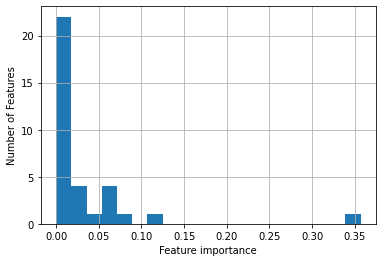

In [9]:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

In [10]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 34
selected features: 8
features with importance greater than the mean importance of all features: 8


In [11]:
selected_feat

Index(['SourceIP', 'DestinationIP', 'SourcePort', 'TimeStamp', 'Duration',
       'PacketLengthMedian', 'PacketLengthMode',
       'PacketTimeStandardDeviation'],
      dtype='object')

In [12]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

In [13]:
X_train.shape, X_test.shape

((37702, 8), (16158, 8))

## Standardize Data




In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

## Classifiers





In [15]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier

## Metrics Evaluation



In [16]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, f1_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

### Logistic Regression




In [17]:
%%time
clf_LR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1).fit(X_train, y_train)

CPU times: user 69.4 ms, sys: 175 ms, total: 245 ms
Wall time: 1.76 s


In [18]:
pred_y_test = clf_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_test))

f1 = f1_score(y_test, pred_y_test)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_test)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.4456042865647946
F1 Score: 0.6109625668449198
FPR: 0.9808062842744923
TPR: 0.9373557815571318


### Naive Bayes




In [19]:
%%time
clf_NB = GaussianNB(var_smoothing=1e-09).fit(X_train, y_train)

CPU times: user 27.7 ms, sys: 7.44 ms, total: 35.1 ms
Wall time: 33.2 ms


In [20]:
pred_y_testNB = clf_NB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testNB))

f1 = f1_score(y_test, pred_y_testNB)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testNB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.3807501488390554
F1 Score: 0.5458197484862599
FPR: 0.9838446717059434
TPR: 0.8012135714896162


### Random Forest






In [21]:
%%time
clf_RF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100).fit(X_train, y_train)

CPU times: user 4.26 s, sys: 46.2 ms, total: 4.3 s
Wall time: 4.3 s


In [22]:
pred_y_testRF = clf_RF.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testRF))

f1 = f1_score(y_test, pred_y_testRF, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testRF)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
FPR: 1.0
TPR: 1.0


### KNN




In [23]:
%%time
clf_KNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance').fit(X_train, y_train)

CPU times: user 7.32 ms, sys: 1.56 ms, total: 8.88 ms
Wall time: 6.97 ms


In [24]:
pred_y_testKNN = clf_KNN.predict(X_test)
print('accuracy_score:', accuracy_score(y_test, pred_y_testKNN))

f1 = f1_score(y_test, pred_y_testKNN)
print('f1:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testKNN)
print('fpr:', fpr[1])
print('tpr:', tpr[1])

accuracy_score: 0.40686644175431635
f1: 0.5631686641332944
fpr: 0.9542018674966651
tpr: 0.8232629689770106


### CatBoost




In [25]:
%%time
clf_CB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04).fit(X_train, y_train)

0:	learn: 0.6561858	total: 62.3ms	remaining: 3.05s
1:	learn: 0.6231428	total: 69.6ms	remaining: 1.67s
2:	learn: 0.5919139	total: 78.2ms	remaining: 1.22s
3:	learn: 0.5629432	total: 86.2ms	remaining: 991ms
4:	learn: 0.5355323	total: 93.8ms	remaining: 844ms
5:	learn: 0.5105457	total: 102ms	remaining: 745ms
6:	learn: 0.4871960	total: 109ms	remaining: 668ms
7:	learn: 0.4649562	total: 116ms	remaining: 611ms
8:	learn: 0.4440026	total: 124ms	remaining: 566ms
9:	learn: 0.4244253	total: 132ms	remaining: 528ms
10:	learn: 0.4059856	total: 141ms	remaining: 499ms
11:	learn: 0.3887868	total: 149ms	remaining: 471ms
12:	learn: 0.3727770	total: 156ms	remaining: 445ms
13:	learn: 0.3573131	total: 164ms	remaining: 423ms
14:	learn: 0.3424779	total: 172ms	remaining: 401ms
15:	learn: 0.3282038	total: 180ms	remaining: 382ms
16:	learn: 0.3152216	total: 187ms	remaining: 363ms
17:	learn: 0.3027600	total: 194ms	remaining: 346ms
18:	learn: 0.2908096	total: 202ms	remaining: 329ms
19:	learn: 0.2801438	total: 209ms	re

In [26]:
pred_y_testCB = clf_CB.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred_y_testCB))

f1 = f1_score(y_test, pred_y_testCB, average='weighted', zero_division=0)
print('F1 Score:', f1)

fpr, tpr, thresholds = roc_curve(y_test, pred_y_testCB)
print('FPR:', fpr[1])
print('TPR:', tpr[1])

Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
FPR: 1.0
TPR: 1.0


## Model Evaluation





In [28]:
import pandas as pd, numpy as np
test_df = pd.read_csv("../KDDTest.csv")
test_df.shape

(22543, 42)

In [29]:
# Create feature matrix X and target vextor y
y_eval = test_df['is_intrusion']
X_eval = test_df.drop(columns=['is_intrusion'])

In [30]:
X_eval = X_eval[selected_feat]

In [31]:
X_eval.shape

(22543, 14)

### Model Evaluation - Logistic Regression




In [32]:
modelLR = linear_model.LogisticRegression(n_jobs=-1, random_state=42, C=0.1)
modelLR.fit(X_train, y_train)

LogisticRegression(C=0.1, n_jobs=-1, random_state=42)

In [33]:
# Predict on the new unseen test data
y_evalpredLR = modelLR.predict(X_eval)
y_predLR = modelLR.predict(X_test)

In [34]:
train_scoreLR = modelLR.score(X_train, y_train)
test_scoreLR = modelLR.score(X_test, y_test)
print("Training accuracy is ", train_scoreLR)
print("Testing accuracy is ", test_scoreLR)

Training accuracy is  0.9344394058168034
Testing accuracy is  0.4456042865647946


In [35]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreLR)
print('F1 Score:',f1_score(y_test, y_predLR))
print('Precision Score:',precision_score(y_test, y_predLR))
print('Recall Score:', recall_score(y_test, y_predLR))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predLR))

Performance measures for test:
--------
Accuracy: 0.4456042865647946
F1 Score: 0.6109625668449198
Precision Score: 0.45316696277320995
Recall Score: 0.9373557815571318
Confusion Matrix:
 [[  259 13235]
 [  733 10968]]


### Cross validation - Logistic Regression




In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelLR, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.82828 (+/- 0.01050)
F1 Score: 0.84277 (+/- 0.01092)
Precision: 0.88000 (+/- 0.00713)
Recall: 0.80860 (+/- 0.01829)


### Model Evaluation - Naive Bayes





In [37]:
modelNB = GaussianNB(var_smoothing=1e-09)
modelNB.fit(X_train, y_train)

GaussianNB()

In [38]:
# Predict on the new unseen test data
y_evalpredNB = modelNB.predict(X_eval)
y_predNB = modelNB.predict(X_test)

In [39]:
train_scoreNB = modelNB.score(X_train, y_train)
test_scoreNB = modelNB.score(X_test, y_test)
print("Training accuracy is ", train_scoreNB)
print("Testing accuracy is ", test_scoreNB)

Training accuracy is  0.9002351727080584
Testing accuracy is  0.3807501488390554


In [40]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreNB)
print('F1 Score:',f1_score(y_test, y_predNB))
print('Precision Score:',precision_score(y_test, y_predNB))
print('Recall Score:', recall_score(y_test, y_predNB))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predNB))

Performance measures for test:
--------
Accuracy: 0.3807501488390554
F1 Score: 0.5458197484862599
Precision Score: 0.4138890115226701
Recall Score: 0.8012135714896162
Confusion Matrix:
 [[  218 13276]
 [ 2326  9375]]


### Cross validation - Naive Bayes





In [41]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelNB, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.78321 (+/- 0.04719)
F1 Score: 0.79129 (+/- 0.06801)
Precision: 0.87087 (+/- 0.03344)
Recall: 0.72873 (+/- 0.12557)


### Model Evaluation - Random Forest




In [42]:
modelRF = RandomForestClassifier(random_state=0,max_depth=70,n_estimators=100)
modelRF.fit(X_train, y_train)

RandomForestClassifier(max_depth=70, random_state=0)

In [43]:
# Predict on the new unseen test data
y_evalpredRF = modelRF.predict(X_eval)
y_predRF = modelRF.predict(X_test)

In [44]:
train_scoreRF = modelRF.score(X_train, y_train)
test_scoreRF = modelRF.score(X_test, y_test)
print("Training accuracy is ", train_scoreRF)
print("Testing accuracy is ", test_scoreRF)

Training accuracy is  0.9999702313027774
Testing accuracy is  0.5355824568366739


In [45]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreRF)
print('F1 Score:', f1_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Precision Score:', precision_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predRF, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predRF))

Performance measures for test:
--------
Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
Precision Score: 0.28684856807120773
Recall Score: 0.5355824568366739
Confusion Matrix:
 [[13494     0]
 [11701     0]]


### Cross validation - Random Forest





In [46]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelRF, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.98678 (+/- 0.00503)
F1 Score: 0.98838 (+/- 0.00442)
Precision: 0.98878 (+/- 0.00671)
Recall: 0.98800 (+/- 0.00620)


### Model Evaluation - KNN



In [47]:
modelKNN = KNeighborsClassifier(algorithm='brute',leaf_size=1,n_neighbors=2,weights='distance')
modelKNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=1, n_neighbors=2,
                     weights='distance')

In [48]:
# Predict on the new unseen test data
y_evalpredKNN = modelKNN.predict(X_eval)
y_predKNN = modelKNN.predict(X_test)

In [49]:
train_scoreKNN = modelKNN.score(X_train, y_train)
test_scoreKNN = modelKNN.score(X_test, y_test)
print("Training accuracy is ", train_scoreKNN)
print("Testing accuracy is ", test_scoreKNN)

Training accuracy is  0.9999702313027774
Testing accuracy is  0.40686644175431635


In [50]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreKNN)
print('F1 Score:', f1_score(y_test, y_predKNN))
print('Precision Score:', precision_score(y_test, y_predKNN))
print('Recall Score:', recall_score(y_test, y_predKNN))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predKNN))

Performance measures for test:
--------
Accuracy: 0.40686644175431635
F1 Score: 0.5631686641332944
Precision Score: 0.42796214847394376
Recall Score: 0.8232629689770106
Confusion Matrix:
 [[  618 12876]
 [ 2068  9633]]


### Cross validation - KNN






In [51]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))

f = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='f1')
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

precision = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))

recall = cross_val_score(modelKNN, X_eval, y_eval, cv=10, scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.97631 (+/- 0.00537)
F1 Score: 0.97916 (+/- 0.00469)
Precision: 0.98085 (+/- 0.00747)
Recall: 0.97748 (+/- 0.00475)


### Model Evaluation - CatBoost





In [52]:
modelCB = CatBoostClassifier(random_state=0,depth=7,iterations=50,learning_rate=0.04)
modelCB.fit(X_train, y_train)

0:	learn: 0.6561858	total: 8ms	remaining: 392ms
1:	learn: 0.6231428	total: 15.7ms	remaining: 376ms
2:	learn: 0.5919139	total: 23ms	remaining: 360ms
3:	learn: 0.5629432	total: 30.3ms	remaining: 349ms
4:	learn: 0.5355323	total: 37.1ms	remaining: 333ms
5:	learn: 0.5105457	total: 44.1ms	remaining: 323ms
6:	learn: 0.4871960	total: 51.1ms	remaining: 314ms
7:	learn: 0.4649562	total: 58.2ms	remaining: 305ms
8:	learn: 0.4440026	total: 65.2ms	remaining: 297ms
9:	learn: 0.4244253	total: 72.4ms	remaining: 289ms
10:	learn: 0.4059856	total: 79.1ms	remaining: 281ms
11:	learn: 0.3887868	total: 87.2ms	remaining: 276ms
12:	learn: 0.3727770	total: 94.6ms	remaining: 269ms
13:	learn: 0.3573131	total: 101ms	remaining: 261ms
14:	learn: 0.3424779	total: 108ms	remaining: 253ms
15:	learn: 0.3282038	total: 115ms	remaining: 245ms
16:	learn: 0.3152216	total: 123ms	remaining: 238ms
17:	learn: 0.3027600	total: 130ms	remaining: 231ms
18:	learn: 0.2908096	total: 137ms	remaining: 223ms
19:	learn: 0.2801438	total: 143ms

In [53]:
# Predict on the new unseen test data
y_evalpredCB = modelCB.predict(X_eval)
y_predCB = modelCB.predict(X_test)

In [54]:
train_scoreCB = modelCB.score(X_train, y_train)
test_scoreCB = modelCB.score(X_test, y_test)
print("Training accuracy is ", train_scoreCB)
print("Testing accuracy is ", test_scoreCB)

Training accuracy is  0.9913273862091548
Testing accuracy is  0.5355824568366739


In [55]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
print('Performance measures for test:')
print('--------')
print('Accuracy:', test_scoreCB)
print('F1 Score:',f1_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Precision Score:',precision_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Recall Score:', recall_score(y_test, y_predCB, average='weighted', zero_division=0))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predCB))

Performance measures for test:
--------
Accuracy: 0.5355824568366739
F1 Score: 0.3736022989766641
Precision Score: 0.28684856807120773
Recall Score: 0.5355824568366739
Confusion Matrix:
 [[13494     0]
 [11701     0]]


### Cross validation - CatBoost





In [56]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics

accuracy = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='accuracy')
f = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='f1')
precision = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='precision')
recall = cross_val_score(modelCB, X_eval, y_eval, cv=10, scoring='recall')

0:	learn: 0.6608264	total: 4.79ms	remaining: 235ms
1:	learn: 0.6310475	total: 9.12ms	remaining: 219ms
2:	learn: 0.6030928	total: 13ms	remaining: 204ms
3:	learn: 0.5783650	total: 17.1ms	remaining: 197ms
4:	learn: 0.5541139	total: 21.4ms	remaining: 193ms
5:	learn: 0.5316774	total: 25.5ms	remaining: 187ms
6:	learn: 0.5105202	total: 29.5ms	remaining: 181ms
7:	learn: 0.4912572	total: 34.2ms	remaining: 179ms
8:	learn: 0.4726965	total: 38.2ms	remaining: 174ms
9:	learn: 0.4552912	total: 42.2ms	remaining: 169ms
10:	learn: 0.4389850	total: 46.1ms	remaining: 164ms
11:	learn: 0.4237376	total: 50.3ms	remaining: 159ms
12:	learn: 0.4092050	total: 54.7ms	remaining: 156ms
13:	learn: 0.3956988	total: 59ms	remaining: 152ms
14:	learn: 0.3828156	total: 63.1ms	remaining: 147ms
15:	learn: 0.3701429	total: 67.2ms	remaining: 143ms
16:	learn: 0.3579634	total: 71.2ms	remaining: 138ms
17:	learn: 0.3461396	total: 75.6ms	remaining: 134ms
18:	learn: 0.3349430	total: 79.7ms	remaining: 130ms
19:	learn: 0.3242548	total

21:	learn: 0.3054198	total: 91.7ms	remaining: 117ms
22:	learn: 0.2962913	total: 95.7ms	remaining: 112ms
23:	learn: 0.2879757	total: 99.6ms	remaining: 108ms
24:	learn: 0.2801136	total: 104ms	remaining: 104ms
25:	learn: 0.2725076	total: 107ms	remaining: 99.1ms
26:	learn: 0.2650677	total: 111ms	remaining: 94.9ms
27:	learn: 0.2578463	total: 116ms	remaining: 91.1ms
28:	learn: 0.2510273	total: 120ms	remaining: 87ms
29:	learn: 0.2441091	total: 124ms	remaining: 83ms
30:	learn: 0.2378851	total: 128ms	remaining: 78.7ms
31:	learn: 0.2319338	total: 132ms	remaining: 74.5ms
32:	learn: 0.2261093	total: 137ms	remaining: 70.5ms
33:	learn: 0.2209322	total: 141ms	remaining: 66.3ms
34:	learn: 0.2152037	total: 145ms	remaining: 62.2ms
35:	learn: 0.2096922	total: 149ms	remaining: 58ms
36:	learn: 0.2049885	total: 153ms	remaining: 53.9ms
37:	learn: 0.2004670	total: 157ms	remaining: 49.7ms
38:	learn: 0.1959697	total: 162ms	remaining: 45.6ms
39:	learn: 0.1913697	total: 166ms	remaining: 41.5ms
40:	learn: 0.187323

30:	learn: 0.2394906	total: 130ms	remaining: 79.4ms
31:	learn: 0.2332356	total: 134ms	remaining: 75.1ms
32:	learn: 0.2277625	total: 138ms	remaining: 70.9ms
33:	learn: 0.2221624	total: 142ms	remaining: 66.6ms
34:	learn: 0.2164280	total: 146ms	remaining: 62.4ms
35:	learn: 0.2113963	total: 150ms	remaining: 58.2ms
36:	learn: 0.2066977	total: 154ms	remaining: 54ms
37:	learn: 0.2020485	total: 158ms	remaining: 49.8ms
38:	learn: 0.1974576	total: 162ms	remaining: 45.7ms
39:	learn: 0.1931531	total: 166ms	remaining: 41.6ms
40:	learn: 0.1891226	total: 170ms	remaining: 37.4ms
41:	learn: 0.1849815	total: 175ms	remaining: 33.2ms
42:	learn: 0.1809661	total: 179ms	remaining: 29.1ms
43:	learn: 0.1773858	total: 183ms	remaining: 25ms
44:	learn: 0.1732332	total: 188ms	remaining: 20.9ms
45:	learn: 0.1698684	total: 192ms	remaining: 16.7ms
46:	learn: 0.1664536	total: 196ms	remaining: 12.5ms
47:	learn: 0.1633860	total: 200ms	remaining: 8.34ms
48:	learn: 0.1604299	total: 205ms	remaining: 4.17ms
49:	learn: 0.157

47:	learn: 0.1594898	total: 201ms	remaining: 8.36ms
48:	learn: 0.1564528	total: 205ms	remaining: 4.17ms
49:	learn: 0.1535768	total: 209ms	remaining: 0us
0:	learn: 0.6608264	total: 4.27ms	remaining: 209ms
1:	learn: 0.6310475	total: 8.68ms	remaining: 208ms
2:	learn: 0.6030928	total: 12.7ms	remaining: 199ms
3:	learn: 0.5783650	total: 16.9ms	remaining: 194ms
4:	learn: 0.5541139	total: 21.2ms	remaining: 191ms
5:	learn: 0.5316774	total: 25.6ms	remaining: 188ms
6:	learn: 0.5105202	total: 29.9ms	remaining: 183ms
7:	learn: 0.4912572	total: 34ms	remaining: 179ms
8:	learn: 0.4726965	total: 38.3ms	remaining: 175ms
9:	learn: 0.4552912	total: 42.6ms	remaining: 170ms
10:	learn: 0.4389850	total: 47ms	remaining: 167ms
11:	learn: 0.4237376	total: 51.1ms	remaining: 162ms
12:	learn: 0.4092050	total: 55.2ms	remaining: 157ms
13:	learn: 0.3956988	total: 59.4ms	remaining: 153ms
14:	learn: 0.3828156	total: 63.6ms	remaining: 148ms
15:	learn: 0.3701429	total: 67.6ms	remaining: 144ms
16:	learn: 0.3579634	total: 7

11:	learn: 0.4251536	total: 49.8ms	remaining: 158ms
12:	learn: 0.4106824	total: 54ms	remaining: 154ms
13:	learn: 0.3967902	total: 58.1ms	remaining: 149ms
14:	learn: 0.3834707	total: 62ms	remaining: 145ms
15:	learn: 0.3713089	total: 66ms	remaining: 140ms
16:	learn: 0.3587460	total: 70ms	remaining: 136ms
17:	learn: 0.3467207	total: 74ms	remaining: 132ms
18:	learn: 0.3355181	total: 78.1ms	remaining: 127ms
19:	learn: 0.3249323	total: 82.4ms	remaining: 124ms
20:	learn: 0.3148493	total: 86.7ms	remaining: 120ms
21:	learn: 0.3054198	total: 91ms	remaining: 116ms
22:	learn: 0.2962913	total: 95.1ms	remaining: 112ms
23:	learn: 0.2879757	total: 99.1ms	remaining: 107ms
24:	learn: 0.2801136	total: 103ms	remaining: 103ms
25:	learn: 0.2725076	total: 107ms	remaining: 99.1ms
26:	learn: 0.2650677	total: 112ms	remaining: 95.1ms
27:	learn: 0.2578463	total: 116ms	remaining: 90.9ms
28:	learn: 0.2510273	total: 120ms	remaining: 86.9ms
29:	learn: 0.2441091	total: 124ms	remaining: 82.8ms
30:	learn: 0.2378851	tota

38:	learn: 0.1974576	total: 163ms	remaining: 45.9ms
39:	learn: 0.1931531	total: 167ms	remaining: 41.7ms
40:	learn: 0.1891226	total: 171ms	remaining: 37.5ms
41:	learn: 0.1849815	total: 175ms	remaining: 33.3ms
42:	learn: 0.1809661	total: 179ms	remaining: 29.1ms
43:	learn: 0.1773858	total: 183ms	remaining: 24.9ms
44:	learn: 0.1732332	total: 187ms	remaining: 20.8ms
45:	learn: 0.1698684	total: 191ms	remaining: 16.6ms
46:	learn: 0.1664536	total: 195ms	remaining: 12.5ms
47:	learn: 0.1633860	total: 200ms	remaining: 8.33ms
48:	learn: 0.1604299	total: 204ms	remaining: 4.16ms
49:	learn: 0.1572230	total: 208ms	remaining: 0us
0:	learn: 0.6617562	total: 4.1ms	remaining: 201ms
1:	learn: 0.6314972	total: 8.35ms	remaining: 200ms
2:	learn: 0.6038603	total: 12.5ms	remaining: 197ms
3:	learn: 0.5783300	total: 17.1ms	remaining: 196ms
4:	learn: 0.5545735	total: 21.1ms	remaining: 190ms
5:	learn: 0.5319247	total: 25.5ms	remaining: 187ms
6:	learn: 0.5110480	total: 29.7ms	remaining: 183ms
7:	learn: 0.4913336	tot

4:	learn: 0.5541139	total: 21.2ms	remaining: 191ms
5:	learn: 0.5316774	total: 25.3ms	remaining: 186ms
6:	learn: 0.5105202	total: 29.2ms	remaining: 180ms
7:	learn: 0.4912572	total: 33.5ms	remaining: 176ms
8:	learn: 0.4726965	total: 38.2ms	remaining: 174ms
9:	learn: 0.4552912	total: 43.1ms	remaining: 173ms
10:	learn: 0.4389850	total: 47.5ms	remaining: 168ms
11:	learn: 0.4237376	total: 52.2ms	remaining: 165ms
12:	learn: 0.4092050	total: 57.2ms	remaining: 163ms
13:	learn: 0.3956988	total: 62ms	remaining: 159ms
14:	learn: 0.3828156	total: 66.6ms	remaining: 155ms
15:	learn: 0.3701429	total: 71.2ms	remaining: 151ms
16:	learn: 0.3579634	total: 75.6ms	remaining: 147ms
17:	learn: 0.3461396	total: 80.4ms	remaining: 143ms
18:	learn: 0.3349430	total: 85.2ms	remaining: 139ms
19:	learn: 0.3242548	total: 89.9ms	remaining: 135ms
20:	learn: 0.3141424	total: 94.5ms	remaining: 130ms
21:	learn: 0.3048134	total: 99ms	remaining: 126ms
22:	learn: 0.2961368	total: 104ms	remaining: 122ms
23:	learn: 0.2871815	to

22:	learn: 0.2962913	total: 96.3ms	remaining: 113ms
23:	learn: 0.2879757	total: 100ms	remaining: 109ms
24:	learn: 0.2801136	total: 104ms	remaining: 104ms
25:	learn: 0.2725076	total: 109ms	remaining: 100ms
26:	learn: 0.2650677	total: 113ms	remaining: 96ms
27:	learn: 0.2578463	total: 117ms	remaining: 91.8ms
28:	learn: 0.2510273	total: 121ms	remaining: 87.4ms
29:	learn: 0.2441091	total: 125ms	remaining: 83.3ms
30:	learn: 0.2378851	total: 129ms	remaining: 79.1ms
31:	learn: 0.2319338	total: 134ms	remaining: 75.3ms
32:	learn: 0.2261093	total: 138ms	remaining: 71.1ms
33:	learn: 0.2209322	total: 142ms	remaining: 66.9ms
34:	learn: 0.2152037	total: 146ms	remaining: 62.7ms
35:	learn: 0.2096922	total: 151ms	remaining: 58.6ms
36:	learn: 0.2049885	total: 155ms	remaining: 54.3ms
37:	learn: 0.2004670	total: 159ms	remaining: 50.2ms
38:	learn: 0.1959697	total: 163ms	remaining: 45.9ms
39:	learn: 0.1913697	total: 167ms	remaining: 41.8ms
40:	learn: 0.1873235	total: 172ms	remaining: 37.8ms
41:	learn: 0.1836

38:	learn: 0.1974576	total: 162ms	remaining: 45.8ms
39:	learn: 0.1931531	total: 167ms	remaining: 41.6ms
40:	learn: 0.1891226	total: 170ms	remaining: 37.4ms
41:	learn: 0.1849815	total: 174ms	remaining: 33.2ms
42:	learn: 0.1809661	total: 178ms	remaining: 29ms
43:	learn: 0.1773858	total: 182ms	remaining: 24.9ms
44:	learn: 0.1732332	total: 186ms	remaining: 20.7ms
45:	learn: 0.1698684	total: 190ms	remaining: 16.6ms
46:	learn: 0.1664536	total: 194ms	remaining: 12.4ms
47:	learn: 0.1633860	total: 199ms	remaining: 8.29ms
48:	learn: 0.1604299	total: 203ms	remaining: 4.15ms
49:	learn: 0.1572230	total: 207ms	remaining: 0us
0:	learn: 0.6617562	total: 4.29ms	remaining: 210ms
1:	learn: 0.6314972	total: 8.5ms	remaining: 204ms
2:	learn: 0.6038603	total: 12.7ms	remaining: 200ms
3:	learn: 0.5783300	total: 17.1ms	remaining: 197ms
4:	learn: 0.5545735	total: 21.3ms	remaining: 191ms
5:	learn: 0.5319247	total: 25.5ms	remaining: 187ms
6:	learn: 0.5110480	total: 30ms	remaining: 184ms
7:	learn: 0.4913336	total: 

1:	learn: 0.6310475	total: 8.71ms	remaining: 209ms
2:	learn: 0.6030928	total: 12.7ms	remaining: 199ms
3:	learn: 0.5783650	total: 16.7ms	remaining: 192ms
4:	learn: 0.5541139	total: 20.6ms	remaining: 186ms
5:	learn: 0.5316774	total: 25ms	remaining: 183ms
6:	learn: 0.5105202	total: 29.1ms	remaining: 179ms
7:	learn: 0.4912572	total: 33.1ms	remaining: 174ms
8:	learn: 0.4726965	total: 37.3ms	remaining: 170ms
9:	learn: 0.4552912	total: 41.6ms	remaining: 166ms
10:	learn: 0.4389850	total: 46ms	remaining: 163ms
11:	learn: 0.4237376	total: 50.1ms	remaining: 159ms
12:	learn: 0.4092050	total: 54ms	remaining: 154ms
13:	learn: 0.3956988	total: 58ms	remaining: 149ms
14:	learn: 0.3828156	total: 62ms	remaining: 145ms
15:	learn: 0.3701429	total: 65.9ms	remaining: 140ms
16:	learn: 0.3579634	total: 69.9ms	remaining: 136ms
17:	learn: 0.3461396	total: 74ms	remaining: 132ms
18:	learn: 0.3349430	total: 78.4ms	remaining: 128ms
19:	learn: 0.3242548	total: 82.6ms	remaining: 124ms
20:	learn: 0.3141424	total: 86.7m

21:	learn: 0.3054198	total: 92.9ms	remaining: 118ms
22:	learn: 0.2962913	total: 97ms	remaining: 114ms
23:	learn: 0.2879757	total: 101ms	remaining: 110ms
24:	learn: 0.2801136	total: 105ms	remaining: 105ms
25:	learn: 0.2725076	total: 109ms	remaining: 100ms
26:	learn: 0.2650677	total: 113ms	remaining: 96.2ms
27:	learn: 0.2578463	total: 117ms	remaining: 91.8ms
28:	learn: 0.2510273	total: 121ms	remaining: 87.9ms
29:	learn: 0.2441091	total: 126ms	remaining: 84ms
30:	learn: 0.2378851	total: 130ms	remaining: 79.9ms
31:	learn: 0.2319338	total: 134ms	remaining: 75.6ms
32:	learn: 0.2261093	total: 139ms	remaining: 71.4ms
33:	learn: 0.2209322	total: 143ms	remaining: 67.1ms
34:	learn: 0.2152037	total: 147ms	remaining: 62.9ms
35:	learn: 0.2096922	total: 151ms	remaining: 58.6ms
36:	learn: 0.2049885	total: 155ms	remaining: 54.5ms
37:	learn: 0.2004670	total: 159ms	remaining: 50.3ms
38:	learn: 0.1959697	total: 164ms	remaining: 46.2ms
39:	learn: 0.1913697	total: 168ms	remaining: 42ms
40:	learn: 0.1873235	

46:	learn: 0.1664536	total: 198ms	remaining: 12.7ms
47:	learn: 0.1633860	total: 203ms	remaining: 8.44ms
48:	learn: 0.1604299	total: 206ms	remaining: 4.21ms
49:	learn: 0.1572230	total: 211ms	remaining: 0us
0:	learn: 0.6617562	total: 4.34ms	remaining: 213ms
1:	learn: 0.6314972	total: 8.67ms	remaining: 208ms
2:	learn: 0.6038603	total: 13ms	remaining: 203ms
3:	learn: 0.5783300	total: 17.2ms	remaining: 197ms
4:	learn: 0.5545735	total: 21.7ms	remaining: 195ms
5:	learn: 0.5319247	total: 25.8ms	remaining: 189ms
6:	learn: 0.5110480	total: 30ms	remaining: 184ms
7:	learn: 0.4913336	total: 34.2ms	remaining: 180ms
8:	learn: 0.4723790	total: 38.8ms	remaining: 177ms
9:	learn: 0.4549037	total: 43.3ms	remaining: 173ms
10:	learn: 0.4384261	total: 47.7ms	remaining: 169ms
11:	learn: 0.4228524	total: 52.7ms	remaining: 167ms
12:	learn: 0.4078996	total: 56.7ms	remaining: 161ms
13:	learn: 0.3940271	total: 60.7ms	remaining: 156ms
14:	learn: 0.3807221	total: 64.8ms	remaining: 151ms
15:	learn: 0.3675440	total: 6

In [57]:
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
print("F1 Score: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))

Accuracy: 0.96549 (+/- 0.00436)
F1 Score: 0.97012 (+/- 0.00376)
Precision: 0.95633 (+/- 0.00720)
Recall: 0.98434 (+/- 0.00733)
